In [1]:
# to suppress TF warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#

import numpy as np

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.keras.backend.set_floatx('float64')
from assigment_utils import *

tf.autograph.set_verbosity(0)

### Generate, split and plot data

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


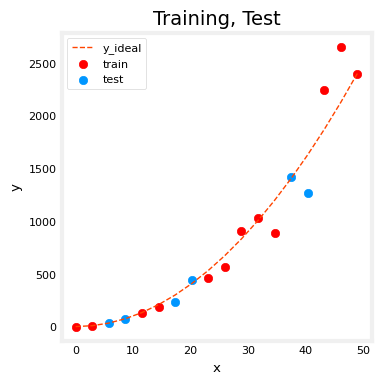

In [2]:
# Generate some data
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

# Plot training and test datasets
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

### use sklearn (polynomial regression model) | compare training and test data errors

training err 58.01, test err 171215.01


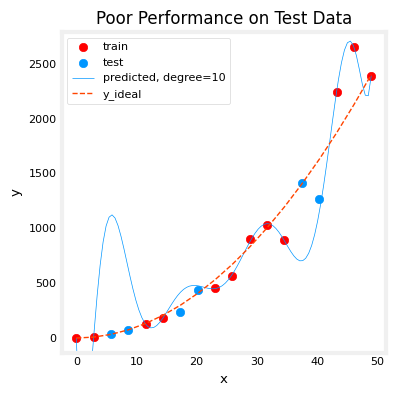

In [3]:
# create a model in sklearn
# --------------------------
degree = 10
linear_model = LinearRegression()
poly = PolynomialFeatures(degree, include_bias=False)
scaler = StandardScaler()

def sklearn_fit(X_train, y_train):
    ## fit_transform() : combination of fit() and transform()
    ## used with training data to get mean and variance.
    X_train_mapped = poly.fit_transform(X_train.reshape(-1,1))
    X_train_mapped_scaled = scaler.fit_transform(X_train_mapped)
    linear_model.fit(X_train_mapped_scaled, y_train)

def sklearn_predict(X):
    ## For predicting use transform() only as we don't want to calculate means/variances of test data
    ## We only want to standardize/scale test data based on variance/mean learned from training data
    X_mapped = poly.transform(X.reshape(-1,1))
    X_mapped_scaled = scaler.transform(X_mapped)
    yhat = linear_model.predict(X_mapped_scaled)
    return yhat

# Fit training data
# ----------------------
sklearn_fit(X_train, y_train)

# Predict training data and find training error
# ----------------------------------------------
yhat = sklearn_predict(X_train)
err_train = mean_squared_error(y_train,yhat)/2

# Predict on test data, find error
# --------------------------------
yhat = sklearn_predict(X_test)
err_test = mean_squared_error(y_test,yhat)/2

print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")

# plot predictions over data range 
x = np.linspace(0,int(X.max()),100)  # predict values for plot

y_pred = sklearn_predict(x)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

The computed error on the training set is substantially less than that of the test set.
The model is over fitting the data (has high variance) and it doesn't generalize well to other data.

### Try to use 3 datasets now (training, CV, test)
Split 60%, 20%, 20%

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


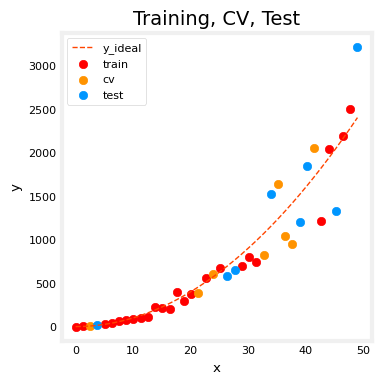

In [4]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

# Plot data
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

### Finding the optimal polynomial degree
Train the model repeatedly, increasing the degree of the polynomial each iteration

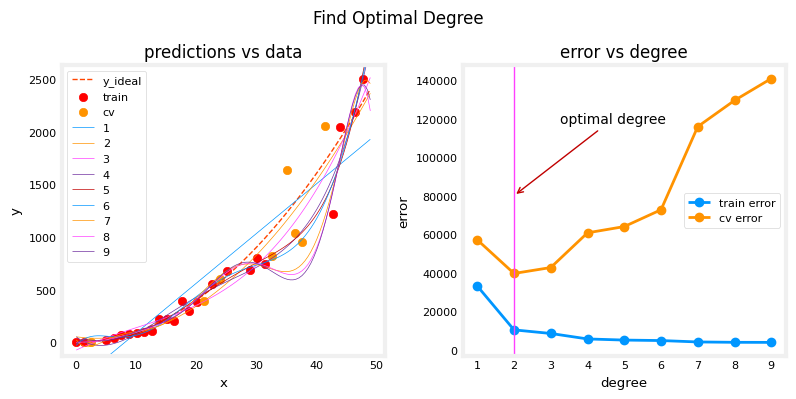

In [5]:
max_degree = 9
err_train = np.zeros(max_degree)    
err_cv = np.zeros(max_degree)      
x = np.linspace(0,int(X.max()),100)  
y_pred = np.zeros((100,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    # Set degree of model
    poly = PolynomialFeatures(degree+1, include_bias=False)
    # Train model
    sklearn_fit(X_train, y_train)
    # Get training error
    yhat = sklearn_predict(X_train)
    err_train[degree] = mean_squared_error(y_train,yhat)/2
    # Get CV error
    yhat = sklearn_predict(X_cv)
    err_cv[degree] = mean_squared_error(y_cv,yhat)/2
    # to plot the prediction curve for all x-axis values
    y_pred[:,degree] = sklearn_predict(x)
    
optimal_degree = np.argmin(err_cv)+1

# Plot results
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)

### Tuning Regularization (lambda)

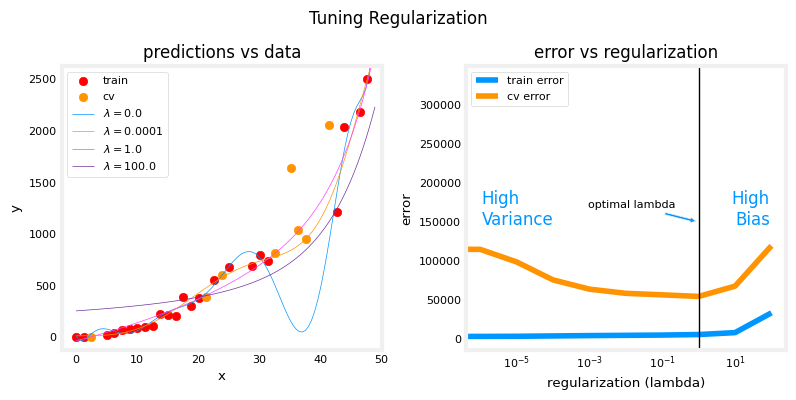

In [6]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()),100) 
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    # loop over different lambda values
    lambda_= lambda_range[i]
    # Set lambda in model
    linear_model = Ridge(alpha=lambda_)
    poly = PolynomialFeatures(degree, include_bias=False)
    scaler = StandardScaler()
    # Train model
    sklearn_fit(X_train, y_train)
    # Get training error
    yhat = sklearn_predict(X_train)
    err_train[i] = mean_squared_error(y_train,yhat)/2
    # Get CV error
    yhat = sklearn_predict(X_cv)
    err_cv[i] = mean_squared_error(y_cv,yhat)/2
    # to plot the prediction curve for all x-axis values
    y_pred[:,i] = sklearn_predict(x)
    
optimal_reg_idx = np.argmin(err_cv)

# Plot results
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

Above, the plots show that as regularization increases, the model moves from a high variance (overfitting) model to a high bias (underfitting) model. The vertical line in the right plot shows the optimal value of lambda. In this example, the polynomial degree was set to 10. 

### Increasing Training Set Size (m)
When a model is overfitting (high variance), collecting additional data can improve performance. Let's try that here.

Note: adding more examples when the model has high bias (underfitting) does not improve performance

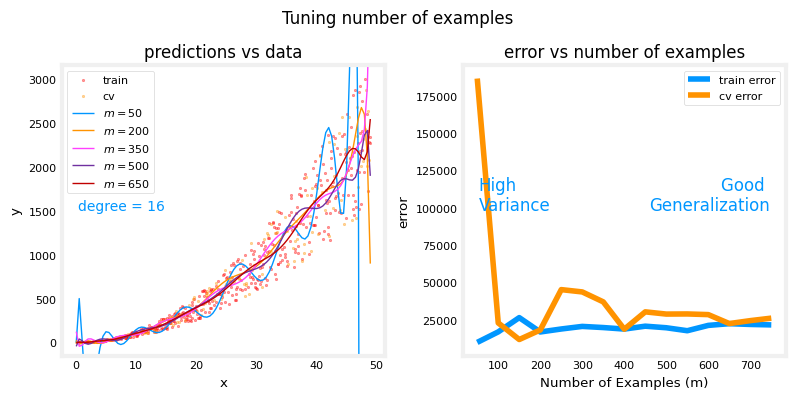

In [7]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

<a name="4"></a>
## NN evaluation / multi-class classification

In [8]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs()

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


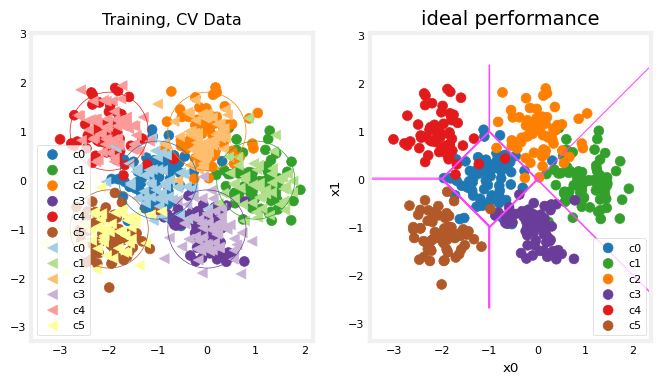

In [9]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

In the picture above, data is on the left. There are six clusters identified by color. Both training points (dots) and cross-validataion points (triangles) are shown.

On the right is an example of an 'ideal' model, or a model one might create knowing the source of the data.

In [10]:
# Classification error
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error (mean of number of misclassified examples)
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    out = np.where(yhat==y, 0, 1)
    cerr = np.mean(out)

    return(cerr)

### Complex NN model

Three-layer model:
* Dense layer with 120 units, relu activation
* Dense layer with 40 units, relu activation
* Dense layer with 6 units and a linear activation (not softmax)

Compilation:
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [18]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        Dense(units=120, activation = "relu"),
        Dense(units=40, activation="relu"),
        Dense(units=6, activation="linear")

    ], name="Complex"
)
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

In [20]:
print("Fitting the model with 1000 epochs (verbose log is disabled)")
model.fit(
    X_train, y_train,
    epochs=1000,
    verbose=0
)

Fitting the model with 1000 epochs (verbose log is disabled)


In [21]:
model.summary()

Model: "Complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 120)               360       
                                                                 
 dense_4 (Dense)             (None, 40)                4840      
                                                                 
 dense_5 (Dense)             (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________


1082/1082 [==============================] - 3s 3ms/step


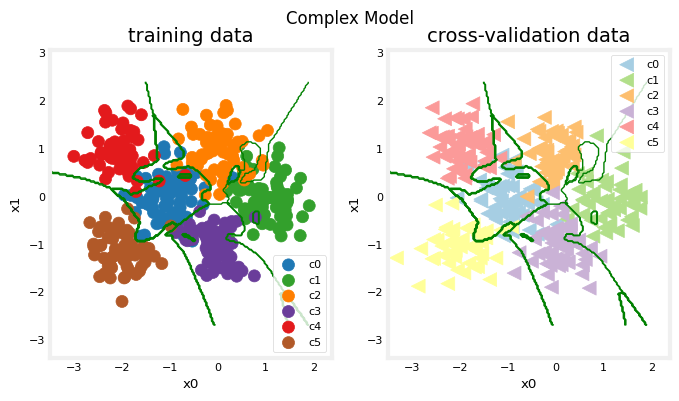

In [22]:
#make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

This model has worked very hard to capture outliers of each category. As a result, it has miscategorized some of the cross-validation data. Let's calculate the classification error.

In [23]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

10/10 [==============================] - 0s 3ms/step
categorization error, training, complex model: 0.007
categorization error, cv,       complex model: 0.122


### Simple NN model

Two-layer model:
* Dense layer with 6 units, relu activation
* Dense layer with 6 units and a linear activation. 

Compile using:
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [24]:
tf.random.set_seed(1234)
model_s = Sequential(
    [
        Dense(units=6, activation = "relu"),
        Dense(units=6, activation="linear")
    ], name = "Simple"
)
model_s.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

In [25]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

print("Fitting the model with 1000 epochs (verbose log is disabled)")
model_s.fit(
    X_train,y_train,
    epochs=1000,
    verbose = 0
)

Fitting the model with 1000 epochs (verbose log is disabled)


In [26]:
model_s.summary()

Model: "Simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 6)                 18        
                                                                 
 dense_7 (Dense)             (None, 6)                 42        
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________


1082/1082 [==============================] - 3s 3ms/step


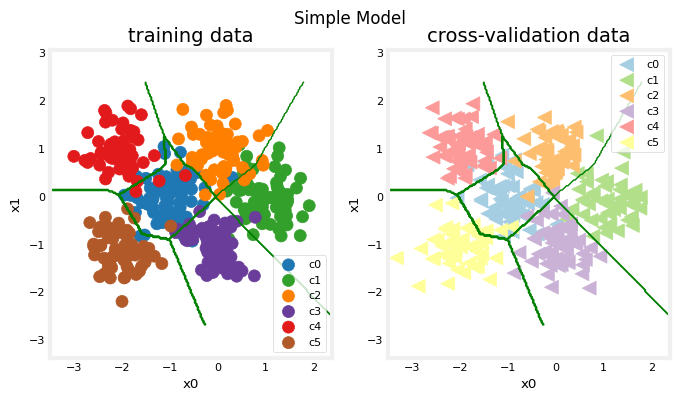

In [27]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

In [28]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

10/10 [==============================] - 0s 4ms/step
categorization error, training, simple model, 0.077, complex model: 0.007
categorization error, cv,       simple model, 0.069, complex model: 0.122


The simple model has a little higher classification error on training data but does better on cross-validation data than the more complex model.

### Regularization with complex NN model
Include regularization in the complex model

Three-layer model:
* Dense layer with 120 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 40 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 6 units and a linear activation. 

Compile using:
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [29]:
tf.random.set_seed(1234)
model_r = Sequential(
    [
        Dense(units=120, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(units=40, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(units=6, activation="linear")
    ], name= "complex_regularized"
)
model_r.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)


In [31]:
print("Fitting the model with 1000 epochs (verbose log is disabled)")
model_r.fit(
    X_train, y_train,
    epochs=1000,
    verbose = 0
)

Fitting the model with 1000 epochs (verbose log is disabled)


In [32]:
model_r.summary()

Model: "complex_regularized"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 120)               360       
                                                                 
 dense_9 (Dense)             (None, 40)                4840      
                                                                 
 dense_10 (Dense)            (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________


1082/1082 [==============================] - 3s 3ms/step


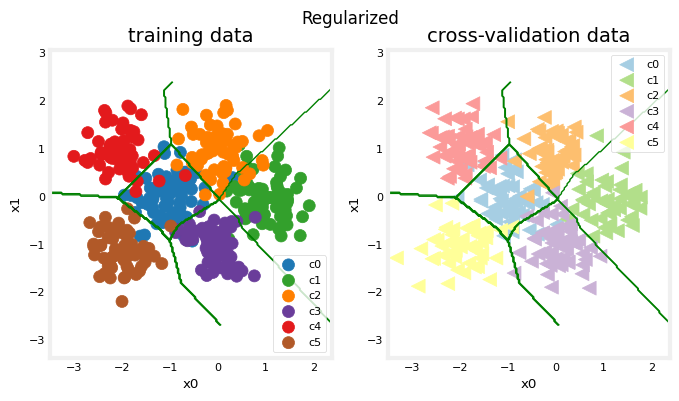

In [33]:
#make a model for plotting routines to call
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

The results look very similar to the 'ideal' model. Let's check classification error.

In [34]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

3/3 [==============================] - 0s 4ms/step
categorization error, training, regularized: 0.062, simple model, 0.077, complex model: 0.007
categorization error, cv,       regularized: 0.062, simple model, 0.069, complex model: 0.122


The simple model is a bit better in the training set than the regularized model but it worse in the cross validation set.

### Iterate to find optimal regularization value

In [35]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )
    
    print("Fitting the model with 1000 epochs (verbose log is disabled)")
    models[i].fit(
        X_train,y_train,
        epochs=1000,
        verbose = 0
    )
    print(f"Finished lambda = {lambda_}")


Fitting the model with 1000 epochs (verbose log is disabled)
Finished lambda = 0.0
Fitting the model with 1000 epochs (verbose log is disabled)
Finished lambda = 0.001
Fitting the model with 1000 epochs (verbose log is disabled)
Finished lambda = 0.01
Fitting the model with 1000 epochs (verbose log is disabled)
Finished lambda = 0.05
Fitting the model with 1000 epochs (verbose log is disabled)
Finished lambda = 0.1
Fitting the model with 1000 epochs (verbose log is disabled)
Finished lambda = 0.2
Fitting the model with 1000 epochs (verbose log is disabled)
Finished lambda = 0.3


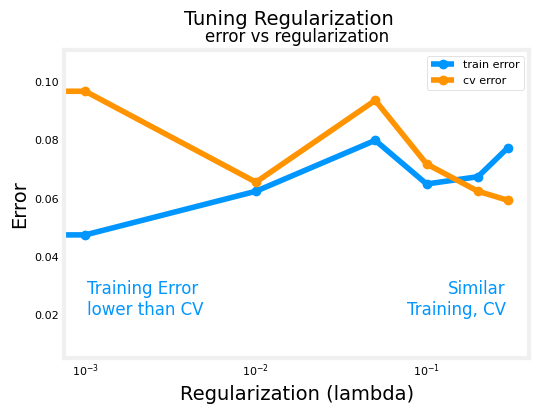

In [38]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

As regularization is increased, the performance of the model on the training and cross-validation data sets converge. For this data set and model, lambda > 0.01 seems to be a reasonable choice.

### Compare models over the test data set

3/3 [==============================] - 0s 3ms/step


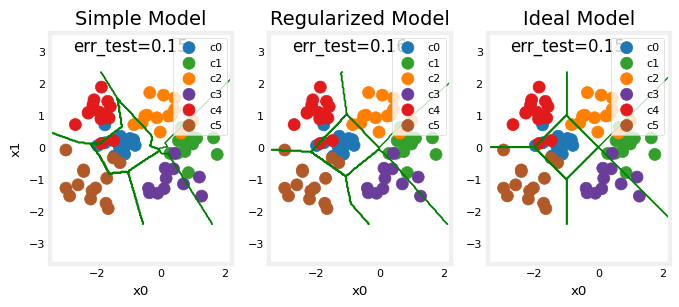

In [39]:
plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)

The test set is small and seems to have a number of outliers so classification error is high. However, the performance of our optimized models is comparable to ideal performance.